In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
cities = pd.read_parquet('./data/cities.parquet')
sales = pd.read_parquet('./data/sales.parquet')
shops = pd.read_parquet('./data/shops.parquet')

## Обработка пропусков в данных

In [3]:
print('Missing values')
print('cities: ', cities.isna().sum().sum())
print('sales: ', sales.isna().sum().sum())
print('shops: ', shops.isna().sum().sum())

Missing values
cities:  0
sales:  0
shops:  317


#### Визуализация пропущенных данных в таблице shops

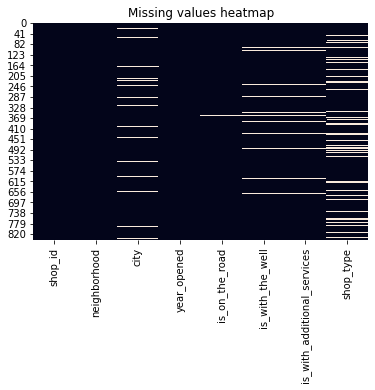

In [4]:
sns.heatmap(shops.isnull(), cbar = False).set_title("Missing values heatmap")
plt.show()

#### Какой процент данных пропущен ?

In [5]:
columns_with_nan = ['city', 
                   'is_on_the_road', 
                   'is_with_the_well',
                   'is_with_additional_services',
                   'shop_type']
shops[columns_with_nan].isna().sum() / shops.shape[0] * 100

city                            6.745562
is_on_the_road                  0.828402
is_with_the_well                7.100592
is_with_additional_services     7.218935
shop_type                      15.621302
dtype: float64

Так как пропущено в среднем не более 10% данных каждой категории, принято решение заменить пропуски случайными значениями выбранной категории, но **с привязкой к владельцам магазинов**

### Добавление информации о владельцах в таблицу shops


In [6]:
# номера магазинов и их владельцы
shops_and_owners = sales[['shop_id', 'owner']].drop_duplicates(ignore_index=True)
shops_and_owners

,shop_id,owner
0,0,Рейдеры
1,1,Рейдеры
2,2,Рейдеры
3,3,Рейдеры
4,4,Рейдеры
...,...,...
997,730,Воины полураспада
998,261,Воины полураспада
999,180,Воины полураспада
1000,782,Воины полураспада


Из таблицы выше следует, что **у некоторого количества магазинов более одного владельца**, так как всего магазинов 845, 
а уникальных соответствий _'shop_id : owner'_  больше тысячи

In [7]:
# формируем таблицу с уникальными соответствиями магазинов и их владельцев
shops_and_owners = shops_and_owners.groupby(['shop_id']).agg(list).reset_index()
shops_and_owners['owner'] = shops_and_owners['owner'].apply(lambda x: ','.join(map(str, x)))
shops_and_owners.groupby('owner').size()

owner
Бомбисты                               14
Воины полураспада                      48
Последователи Апокалипсиса             13
Рейдеры                               555
Рейдеры,Бомбисты                        4
Рейдеры,Воины полураспада             107
Рейдеры,Последователи Апокалипсиса     43
Стервятники                            58
Стервятники,Воины полураспада           3
dtype: int64

In [8]:
# теперь можно добавить информацию о владельцах в таблицу магазинов
shops = shops.merge(shops_and_owners, how='left', on='shop_id')

### Заполнение пропусков в данных с использованием информации о владельцах

Идея состоит в том, что определенные владельцы имеют магазины в определенных городах, с какими-то определенными характеристиками (например Бомбисты владеют магазинами только в двух городах : Газтаун и Свинцовая Ферма,относящихся, в свою очередь, к одной локации) и было бы ошибочно определить магазины Бомбистов с отсутствующей информации о местонахождении к какой-то другой локации, отличной от Радиоактивной Пустоши.

Поэтому принято решение заполнять пропуски случайно выбранными значениями из тех, которые соответствуют каждому владельцу.

In [9]:
def fill_nan(shops: pd.DataFrame, columns_to_fill: list):
    for column in columns_to_fill:

        for index, row in shops[shops[column].isna()].iterrows():
            shops[column].iloc[index] = np.random.choice(shops[shops.owner == row['owner']][column].dropna())
    return shops

In [10]:
# заполняем пропуски в исходной таблице shops
shops = fill_nan(shops, columns_with_nan)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Добавление информации о локации в таблицу shops

In [11]:
shops = shops.merge(cities, how='left', on='city')

In [12]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,owner,location
0,705,В центре,Крепость Джита,2109,нет,да,да,1,Рейдеры,Скалистый Могильник
1,601,В центре,Суховей,2137,нет,нет,нет,4,Рейдеры,Скалистый Могильник
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,2,"Рейдеры,Воины полураспада",Скалистый Могильник
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1,Рейдеры,Свистящие Степи
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2,"Рейдеры,Воины полураспада",Свистящие Степи


#### Добавление информации о дне недели  и месяце продажи в таблицу sales

In [13]:
sales['dow'] = sales['date'].apply(lambda x: x.strftime('%A'))
sales['month'] = sales['date'].dt.month

In [14]:
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold,dow,month
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0,Saturday,1
1,2146-01-01,0,Рейдеры,4,Хлам,26.0,Saturday,1
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0,Saturday,1
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0,Saturday,1
4,2146-01-01,1,Рейдеры,5,Хлам,9.0,Saturday,1


## Шкалирование данных об объеме продаж

В таблице sales предстваленны данные об объемах продаж каждого товара в разрезе дней. 

Так как сравнивать объемы проданного бензака с объемами, например, съедобного хлама некорректно, принято решение отшкалировать данные по каждому типу товара и соединить в одну фичу "total_items_scaled"

In [15]:
pd.options.mode.chained_assignment = None

for good in sales['goods_type'].unique():
    df = sales[sales['goods_type'] == good]
    scaler = MinMaxScaler()
    s = scaler.fit_transform(df['total_items_sold'].values.reshape(-1, 1))
    df['scale'] = s.flatten()
    
    sales = sales.merge(df[['date', 'shop_id','owner', 'goods_type', 'scale']], how = 'left', on = ['date', 'shop_id','owner', 'goods_type'])

df_to_drop = sales.filter(regex= "scal.")
sales['total_items_scaled'] = df_to_drop.sum(axis=1)
sales.drop(df_to_drop.columns, axis=1, inplace=True)  

pd.options.mode.chained_assignment = 'warn'

In [16]:
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold,dow,month,total_items_scaled
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0,Saturday,1,0.016079
1,2146-01-01,0,Рейдеры,4,Хлам,26.0,Saturday,1,0.026715
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0,Saturday,1,0.043123
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0,Saturday,1,0.017494
4,2146-01-01,1,Рейдеры,5,Хлам,9.0,Saturday,1,0.024234


## Генерация фичей

### Доля проданных товаров (отшкалированных) каждой категории в магазине в  разрезе месяцев и дней недели

In [17]:
def goods_share(sales: pd.DataFrame, section: str):

    goods_sold = sales.groupby(['shop_id', 'goods_type', section]).sum()['total_items_scaled'].reset_index()
    total_sold = sales.groupby(['shop_id', section]).sum()['total_items_scaled'].reset_index()
    goods_sold = goods_sold.merge(total_sold, how = 'left', on = ['shop_id', section])
    goods_sold['share_of_goods'] = goods_sold['total_items_scaled_x'] / goods_sold['total_items_scaled_y']
    goods_sold = goods_sold[['shop_id', section, 'goods_type', 'share_of_goods']]
    
    if section == 'month':
        goods_sold['goods_type'] = goods_sold['goods_type']+'_' + goods_sold[section].astype(str) + section
    else:
        goods_sold['goods_type'] = goods_sold['goods_type']+'_' + goods_sold[section]
    
    items_sold_features = goods_sold.pivot(index='shop_id',
                                                 columns='goods_type',
                                                 values='share_of_goods').fillna(0)
    return items_sold_features

In [18]:
# добавление фичей в таблицу shops
shops = shops.merge(goods_share(sales, 'month'), on = 'shop_id')
shops = shops.merge(goods_share(sales, 'dow'), on = 'shop_id')

### Cреднее количество продавцов в магазине в каждый день недели

In [19]:
counters_dow = sales.groupby(['shop_id', 'dow']).mean()['number_of_counters'].reset_index()
counters_dow['dow'] = 'counters_in_' + counters_dow['dow']

# формирование фичей : среднее количество продавцов в магазине в каждый день недели
counters_dow_features = counters_dow.pivot(index='shop_id',
                                           columns='dow',
                                           values='number_of_counters').fillna(0)
# добавление фичей в таблицу shops
shops = shops.merge(counters_dow_features, on = 'shop_id')

In [20]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,owner,location,...,Ядер-Кола_Thursday,Ядер-Кола_Tuesday,Ядер-Кола_Wednesday,counters_in_Friday,counters_in_Monday,counters_in_Saturday,counters_in_Sunday,counters_in_Thursday,counters_in_Tuesday,counters_in_Wednesday
0,705,В центре,Крепость Джита,2109,нет,да,да,1,Рейдеры,Скалистый Могильник,...,0.089558,0.093838,0.093217,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.981601
1,601,В центре,Суховей,2137,нет,нет,нет,4,Рейдеры,Скалистый Могильник,...,0.000000,0.000000,0.000000,4.990338,4.995146,4.980861,4.990385,5.000000,5.000000,5.000000
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,2,"Рейдеры,Воины полураспада",Скалистый Могильник,...,0.086227,0.092183,0.090652,5.980595,6.000000,5.972477,6.000000,5.991184,5.989664,5.980745
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1,Рейдеры,Свистящие Степи,...,0.080282,0.081516,0.079936,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2,"Рейдеры,Воины полураспада",Свистящие Степи,...,0.098592,0.101826,0.100775,5.950888,5.959417,5.942166,5.990683,5.961962,5.993637,5.990854


## Кодирование категориальных переменных

In [21]:
categorical_columns = ['neighborhood',
                       'city', 
                       'is_on_the_road', 
                       'is_with_the_well',
                       'is_with_additional_services',
                       'location',
                       'owner',
                       'shop_type']

dummies = pd.get_dummies(shops[categorical_columns])

In [22]:
shops = shops.join(dummies)

In [23]:
shops.head()

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,owner,location,...,owner_Рейдеры,"owner_Рейдеры,Бомбисты","owner_Рейдеры,Воины полураспада","owner_Рейдеры,Последователи Апокалипсиса",owner_Стервятники,"owner_Стервятники,Воины полураспада",shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,705,В центре,Крепость Джита,2109,нет,да,да,1,Рейдеры,Скалистый Могильник,...,1,0,0,0,0,0,1,0,0,0
1,601,В центре,Суховей,2137,нет,нет,нет,4,Рейдеры,Скалистый Могильник,...,1,0,0,0,0,0,0,0,0,1
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,2,"Рейдеры,Воины полураспада",Скалистый Могильник,...,0,0,1,0,0,0,0,1,0,0
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1,Рейдеры,Свистящие Степи,...,1,0,0,0,0,0,1,0,0,0
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2,"Рейдеры,Воины полураспада",Свистящие Степи,...,0,0,1,0,0,0,0,1,0,0


### Запись новой таблицы в файл

In [24]:
table = pa.Table.from_pandas(shops)

pq.write_to_dataset(
    table,
    root_path='./output.parquet')